In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, plot_confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import cross_val_score, StratifiedKFold, KFold
from sklearn.pipeline import make_pipeline

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

from pandas.plotting import table 

from imblearn.over_sampling import SMOTE

In [2]:
plt.rcParams['font.size'] = 8
plt.rc('font', size=10) 

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
encoded_df = pd.read_pickle('../data/encoded_df.pkl')
encoded_df.head()

,I identify as having a mental illness,Education,I have my own computer separate from a smart phone,I have been hospitalized before for my mental illness,How many days were you hospitalized for your mental illness,I am legally disabled,I have my regular access to the internet,I live with my parents,I have a gap in my resume,Total gaps in resume in months,Annual income (including any social welfare programs) in USD,I am unemployed,I read outside of work and school,Annual income from social welfare programs,I receive food stamps,I am on section 8 housing,How many times were you hospitalized for your mental illness,Lack of concentration,Anxiety,Depression,Obsessive_thinking,Mood_swings,Panic_attacks,Compulsive_behavior,Tiredness,Age,Gender,Household Income,Region_East North Central,Region_East South Central,Region_Middle Atlantic,Region_Mountain,Region_New England,Region_Pacific,Region_South Atlantic,Region_West North Central,Region_West South Central,Device Type_Android Phone / Tablet,Device Type_MacOS Desktop / Laptop,Device Type_Other,Device Type_Windows Desktop / Laptop,Device Type_iOS Phone / Tablet,time_to_complete
0,0,1,0,0,0,0,1,0,1,24,35,1,1,0,0,0,0,1,1,1,1,0,1,0,0,1,0,3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,188.0
1,1,5,1,0,0,0,1,0,0,1,22,0,1,0,0,0,0,1,1,1,0,0,1,0,1,0,0,4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,65.0
2,0,3,1,0,0,0,1,0,0,0,100,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,8,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,141.0
3,0,2,1,0,0,0,1,1,1,11,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,77.0
4,1,3,1,1,35,1,1,0,1,33,32,0,1,30,0,0,4,1,1,1,1,1,1,1,1,1,0,3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,142.0


### Establish Numeric Columns for Scaling
- excluding binary cols and categorical cols that have been encoded

In [4]:
features_to_scale = ['How many days were you hospitalized for your mental illness',
                     'Total gaps in resume in months',
                     'Annual income (including any social welfare programs) in USD',
                     'Annual income from social welfare programs',
                     'How many times were you hospitalized for your mental illness',
                     'time_to_complete'
                    ]

### Function for properly scaling the numerical data

In [5]:
# A good replacement for this function would be to use the ColumnTransformer with a Pipeline
# Though since this data needed such robust cleaning and processing, it seemed appropriate to handle this way
def scale_and_merge(train_data, test_data, cols_to_scale):
    scaler = StandardScaler()
    train_scaled_features = scaler.fit_transform(train_data[cols_to_scale])
    train_scaled_features_df = pd.DataFrame(train_scaled_features, columns=cols_to_scale)
    
    training_scaled_df = train_data.drop(features_to_scale, axis=1)
    training_scaled_df.join(train_scaled_features_df)
    
    test_scaled_features = scaler.transform(test_data[cols_to_scale])
    test_scaled_features_df = pd.DataFrame(test_scaled_features, columns=cols_to_scale)
    
    test_scaled_df = test_data.drop(features_to_scale, axis=1)
    test_scaled_df.join(test_scaled_features_df)
    
    return training_scaled_df, test_scaled_df

# Modeling

## Question: Can we predict unemployment from mental health data?
### Target: 'I am unemployed'

#### V1 - using all features in cleaned df

###### Notes:
Stratify the train-test split to ensure even distribution of classes between the splits

In [6]:
random_seed = 13

y = encoded_df['I am unemployed']
X = encoded_df.drop('I am unemployed', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state=random_seed, stratify=y)
X_train_scaled, X_test_scaled  = scale_and_merge(X_train, X_test, features_to_scale)

In [7]:
def run_cfv(model, X, y, stratify=True):
    cv = KFold(n_splits=5, random_state=random_seed, shuffle=True)
    if stratify:
        cv = StratifiedKFold(n_splits=5, random_state=random_seed, shuffle=True)
    
    score_types = {'Accuracy':'accuracy','Precision':'precision', 'Recall':'recall', 'F1':'f1'}
       
    for name, score in score_types.items():
        cv_scores = cross_val_score(model, X, y, cv=cv, scoring=score)
        print(f'{name} scores: {cv_scores}')
        print(f'\t{name} mean: {cv_scores.mean()}')   

In [8]:
def score_fitted_model(model, X_test, y_test, file_name=None, title=None):
    target_labels = ['Employed', 'Unemployed']
    
    y_hat = model.predict(X_test)
    
    score_types = {'Accuracy':accuracy_score,'Precision':precision_score, 'Recall':recall_score, 'F1':f1_score}
    
    for metric_name, metric_func in score_types.items():
        print(f'{metric_name}: {round(metric_func(y_test, y_hat),2)}')
    
    fig, ax = plt.subplots(figsize=(4,4))
    if title: 
        ax.set_title(title)
        
    plot_confusion_matrix(model, X_test, y_test, display_labels=target_labels, ax=ax, cmap='viridis')
    if file_name:
        plt.savefig(f'../img/{file_name}.png', bbox_inches="tight")
    plt.show()
    
    #print(classification_report(y_true=y_test, y_pred=y_hat, target_names=target_labels))

### Logistic Regression Model

Accuracy: 0.76
Precision: 0.55
Recall: 0.35
F1: 0.43


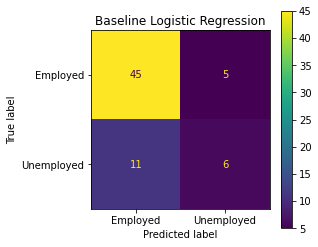

In [9]:
lr = LogisticRegression()

lr.fit(X_train_scaled, y_train)

score_fitted_model(lr, X_test_scaled, y_test, file_name='conf_mat_baseline_log_reg', title='Baseline Logistic Regression')

### RandomForest

Accuracy: 0.76
Precision: 0.57
Recall: 0.24
F1: 0.33


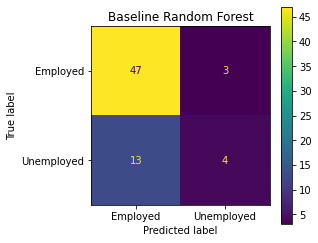

In [10]:
rf_clf = RandomForestClassifier(random_state=random_seed)
rf_clf.fit(X_train, y_train)

score_fitted_model(rf_clf, X_test, y_test, file_name='conf_mat_baseline_rand_for', title='Baseline Random Forest')

The top 20 features

In [11]:
pd.Series(index=X.columns, data=rf_clf.feature_importances_).sort_values(ascending=False)[:10].round(3)

Annual income (including any social welfare programs) in USD    0.093
time_to_complete                                                0.083
Household Income                                                0.082
Total gaps in resume in months                                  0.082
Education                                                       0.066
Age                                                             0.048
I am legally disabled                                           0.042
Annual income from social welfare programs                      0.040
I have a gap in my resume                                       0.030
Region_East North Central                                       0.024
dtype: float64

In [12]:
def print_pd_table(save_df, fsize, filename):
    fig, ax = plt.subplots(figsize=(8,3)) # set size frame
    ax.xaxis.set_visible(False)  # hide the x axis
    ax.yaxis.set_visible(False)  # hide the y axis
    ax.set_frame_on(False)  # no visible frame, uncomment if size is ok
    tabla = table(ax, save_df, loc='upper right', colWidths=[.2]*len(save_df.columns))
    tabla.auto_set_font_size(False) # Activate set fontsize manually
    tabla.set_fontsize(12) # if ++fontsize is necessary ++colWidths
    tabla.scale(1.2, 1.2) # change size table
    #plt.savefig('table.png', transparent=True)
    plt.tight_layout()
    plt.savefig(filename, transparent=True)

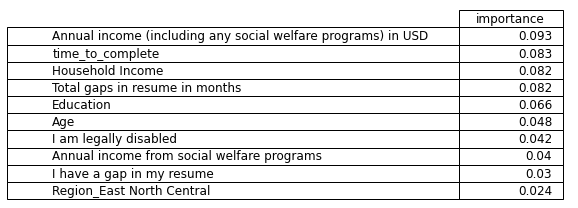

In [13]:
save_df = pd.DataFrame(index=X.columns, data=rf_clf.feature_importances_, columns=['importance']).sort_values(by='importance', ascending=False)[:10].round(3)
print_pd_table(save_df, (8,3), '../img/baseline_feature_importance2.png')

In [14]:
save_df

,importance
Annual income (including any social welfare programs) in USD,0.093
time_to_complete,0.083
Household Income,0.082
Total gaps in resume in months,0.082
Education,0.066
Age,0.048
I am legally disabled,0.042
Annual income from social welfare programs,0.040
I have a gap in my resume,0.030
Region_East North Central,0.024


#### Interpreting results.
##### Accuracy and precision are pretty good, but the recall score is not. 
What is the best metric for this case? The cost of a false positive, i.e. predicting someone will become unemployed but they don't, is not likely a great concern, so precision is going to be primary.

On the other hand, a false negative of predicing a person won't become unemployed but does, would mostly likely be a case we would want to avoid the most. Therefore, recall is more important than precision or accuracy.

F1 is a balance of recall and precision. As expected it is somewhere inbetween the two, but it is most helpful in situations where there is a class imbalance and there are more actual negatives. This is the case with our data where we have about a 3:1 ratio of negative to positive target responses. So the F1 score may be the best score for our case.

#### V2 - Hyperparameter Tuning with All Features in Data

In [15]:
def tune_model(X, y, pipe, params):
    gridsearch = GridSearchCV(estimator=pipe, param_grid=params, scoring='f1', verbose=2, n_jobs=-1).fit(X, y)
    print(f'Best F1 Score: {gridsearch.score(X, y)}')
    
    best_params = gridsearch.best_params_
    print(best_params)
    
    return gridsearch    

In [16]:
pipe_lr = Pipeline(steps=[
    ('estimator', LogisticRegression(max_iter=600, random_state=random_seed))
])

# define parameter ranges in dict
# use double underscore to link pipline object with param name -
# - use the label created when defining the pipe for the test left of the '__'
params_lr = {
    'estimator__solver' : ['lbfgs','liblinear', 'saga'],
    'estimator__penalty' : ['l1','l2','elasticnet'],
    'estimator__class_weight' : ['balanced', None]
}

gridpipe_lr = tune_model(X_train_scaled, y_train, pipe_lr, params_lr)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best F1 Score: 0.6503067484662577
{'estimator__class_weight': 'balanced', 'estimator__penalty': 'l2', 'estimator__solver': 'lbfgs'}


/home/cgridley/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan 0.4913399  0.48171868 0.51274222 0.50358734 0.51274222
        nan        nan        nan        nan 0.49060041 0.4953435
 0.4493239  0.4493239  0.4493239         nan        nan        nan]
  warnings.warn(


Accuracy: 0.72
Precision: 0.46
Recall: 0.65
F1: 0.54


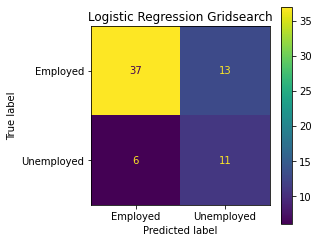

In [17]:
score_fitted_model(gridpipe_lr, X_test_scaled, y_test, file_name='conf_mat_log_reg_gridsearch', title='Logistic Regression Gridsearch')

In [18]:
pipe_rf = Pipeline(steps=[
    ## RandomForests/Decision Trees don't benefit from scaling('scaler', StandardScaler()),
    ('estimator', RandomForestClassifier(random_state=random_seed))
])

# define parameter ranges in dict
# use double underscore to link pipline object with param name -
# - use the label created when defining the pipe for the test left of the '__'
params_rf = {
    'estimator__n_estimators' : np.arange(40, 111, 10),
    'estimator__max_depth' : np.arange(8, 20, 1),
    'estimator__max_features' : ['auto', 'sqrt', 'log2']
}

gridpipe_rf = tune_model(X_train, y_train, pipe_rf, params_rf)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits
Best F1 Score: 0.9777777777777777
{'estimator__max_depth': 11, 'estimator__max_features': 'log2', 'estimator__n_estimators': 110}


Accuracy: 0.76
Precision: 0.56
Recall: 0.29
F1: 0.38


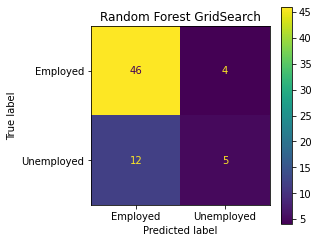

In [19]:
score_fitted_model(gridpipe_rf, X_test, y_test, file_name='conf_mat_rand_for_gridsearch', title='Random Forest GridSearch')

#### Feature importances of best model from GridSearchCV

In [20]:
pd.Series(index=X_test.columns, data=gridpipe_rf.best_estimator_['estimator'].feature_importances_).sort_values(ascending=False)[:10].round(3)

Total gaps in resume in months                                  0.096
Annual income (including any social welfare programs) in USD    0.091
time_to_complete                                                0.085
Household Income                                                0.070
Education                                                       0.061
Age                                                             0.041
I am legally disabled                                           0.039
Annual income from social welfare programs                      0.039
I have a gap in my resume                                       0.028
How many times were you hospitalized for your mental illness    0.027
dtype: float64

## Results So Far
The logistic regression is outperforming the RandomForest. Gridsearch improved recall for the Logistic Regression model by .3 and F1 by .2 and barely improved the Random Forest much.

The feature importances for the Random Forest remained roughly the same after using GridSearchCV.

## V3 - Using Recusive Feature Elimination To Find Best Features

In [21]:
def plot_best_num_of_features(model, rfecv, rfe_scoring, base_filename):
    plt.figure(figsize=(8,4))
    plt.title(f'{model.__class__.__name__} Recusive Feature Elimination with CV Results' )
    plt.xlabel('Num of features selected', fontsize=12, labelpad=20)
    plt.ylabel(f'{rfe_scoring.capitalize()} Score',fontsize=12, labelpad=20)
    plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, linewidth=3, color='darkcyan')
    plt.savefig(f'../img/{base_filename}_rfe_num_features.png', bbox_inches='tight')
    plt.show()
    
    print('Optimal number of features: {}'.format(rfecv.n_features_))

In [22]:
def get_top_rfe_features(X, rfecv):
    M = np.array([X.columns, rfecv.ranking_])
    df_rfe = pd.DataFrame(data=M.T, columns=['feature', 'ranking'])
    
    top_features = df_rfe[df_rfe['ranking']==1]
    display(top_features)
    
    X_most_imp = X[top_features['feature']].copy()
    
    return X_most_imp

In [23]:
def run_rfe(X, y, model, base_filename, rfe_scoring='f1', scale_features=False):
    """
    
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state=random_seed, stratify=y)
    X_train_scaled, X_test_scaled  = scale_and_merge(X_train, X_test, features_to_scale)
    
    rfecv = RFECV(estimator=model, step=1, cv=StratifiedKFold(10), scoring=rfe_scoring, n_jobs=-1)
    
    if scale_features:
        # there will be some data leakage here since we are scaling all the data being fit in the rfecv but it should be acceptable since it isn't affecting the model scoring
        rfecv.fit(X_train_scaled, y_train)
        most_imp = get_top_rfe_features(X_train_scaled, rfecv).columns
    else:  
        rfecv.fit(X_train, y_train)
        most_imp = get_top_rfe_features(X_train, rfecv).columns
    
    plot_best_num_of_features(model, rfecv, rfe_scoring, base_filename)
              
    print('Re-run the model with only the most important features of the same train-test split data used in the previous modeling so we can accurately compare the results.')
    print('')
    if scale_features:
        model.fit(X_train_scaled[most_imp], y_train)
        score_fitted_model(model, X_test_scaled[most_imp], y_test, file_name=f'{base_filename}_conf_mat_rfe', title=f'{model.__class__.__name__} with RFECV')
    else:
        model.fit(X_train[most_imp], y_train)
        score_fitted_model(model, X_test[most_imp], y_test, file_name=f'{base_filename}_conf_mat_rfe', title=f'{model.__class__.__name__} with RFECV')
    
    return most_imp, model

### RFECV with Random Forest

,feature,ranking
1,Education,1
2,I have my own computer separate from a smart p...,1
4,How many days were you hospitalized for your m...,1
5,I am legally disabled,1
8,I have a gap in my resume,1
9,Total gaps in resume in months,1
10,Annual income (including any social welfare pr...,1
12,Annual income from social welfare programs,1
15,How many times were you hospitalized for your ...,1
17,Anxiety,1


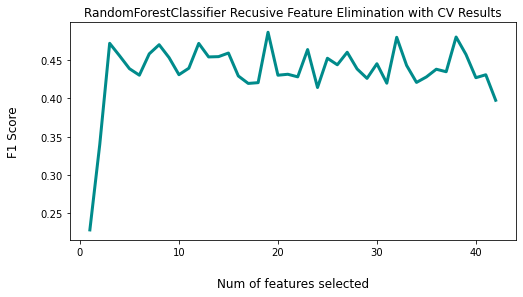

Optimal number of features: 19
Re-run the model with only the most important features of the same train-test split data used in the previous modeling so we can accurately compare the results.

Accuracy: 0.82
Precision: 0.73
Recall: 0.47
F1: 0.57


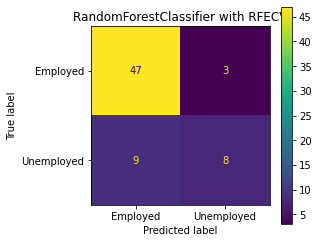

In [24]:
X_most_imp_rand_for, rf_rfe_model = run_rfe(X, y, RandomForestClassifier(random_state=random_seed), base_filename='rand_forest')

#### Notice the engineered feature, "time_to_complete" is one of the most important

### RFECV with Logistic Regression

,feature,ranking
0,I identify as having a mental illness,1
1,Education,1
2,I have my own computer separate from a smart p...,1
3,I have been hospitalized before for my mental ...,1
4,I am legally disabled,1
5,I have my regular access to the internet,1
6,I live with my parents,1
7,I have a gap in my resume,1
8,I read outside of work and school,1
9,I receive food stamps,1


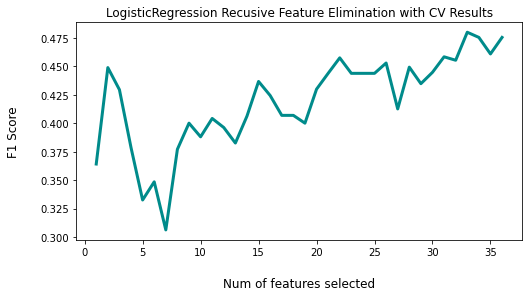

Optimal number of features: 33
Re-run the model with only the most important features of the same train-test split data used in the previous modeling so we can accurately compare the results.

Accuracy: 0.76
Precision: 0.55
Recall: 0.35
F1: 0.43


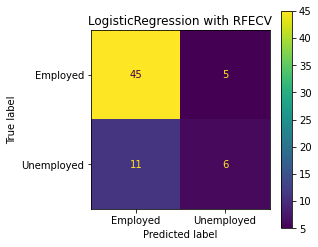

In [25]:
X_most_imp_log_reg, lr_rfe_model = run_rfe(X, y, LogisticRegression(random_state=random_seed), base_filename='logistic_regression', scale_features=True)

### Does Hyperparameter tuning with Gridsearch help the Random Forest?

In [26]:
X_most_imp = X[X_most_imp_rand_for].copy()

In [27]:
# recreating the train test split from the RFECV function
X_train_rfe, X_test_rfe, y_train_rfe, y_test_rfe = train_test_split(X_most_imp, y, test_size = .2, random_state=random_seed, stratify=y)

In [28]:
pipe_rf_rfe = Pipeline(steps=[
    ## RandomForests/Decision Trees don't benefit from scaling('scaler', StandardScaler()),
    ('estimator', RandomForestClassifier(random_state=random_seed))
])

# define parameter ranges in dict
# use double underscore to link pipline object with param name -
# - use the label created when defining the pipe for the test left of the '__'
params_rf_rfe = {
    'estimator__n_estimators' : np.arange(40, 111, 10),
    'estimator__max_depth' : np.arange(8, 20, 1),
    'estimator__max_features' : ['auto', 'sqrt', 'log2']
}

gridpipe_rf_rfe = tune_model(X_train_rfe, y_train_rfe, pipe_rf_rfe, params_rf_rfe)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits
Best F1 Score: 1.0
{'estimator__max_depth': 16, 'estimator__max_features': 'auto', 'estimator__n_estimators': 60}


Accuracy: 0.75
Precision: 0.5
Recall: 0.29
F1: 0.37


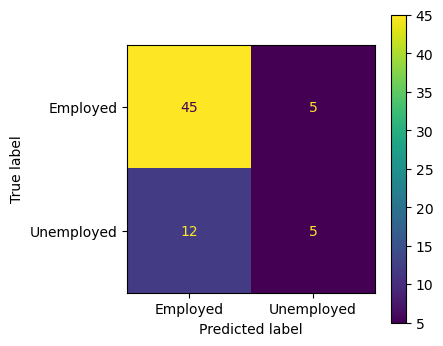

In [29]:
plt.rcParams.update(plt.rcParamsDefault)
score_fitted_model(gridpipe_rf_rfe, X_test_rfe, y_test_rfe, file_name='conf_mat_rfe_gridsearch')

## No, it doesn't improve things

## Using SMOTE for Oversampling to Balance Classes

In [30]:
smote = SMOTE()
X_sm, y_sm = smote.fit_resample(X, y)

In [31]:
X_sm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 492 entries, 0 to 491
Data columns (total 42 columns):
 #   Column                                                        Non-Null Count  Dtype  
---  ------                                                        --------------  -----  
 0   I identify as having a mental illness                         492 non-null    int64  
 1   Education                                                     492 non-null    int64  
 2   I have my own computer separate from a smart phone            492 non-null    int64  
 3   I have been hospitalized before for my mental illness         492 non-null    int64  
 4   How many days were you hospitalized for your mental illness   492 non-null    int64  
 5   I am legally disabled                                         492 non-null    int64  
 6   I have my regular access to the internet                      492 non-null    int64  
 7   I live with my parents                                        492 non-n

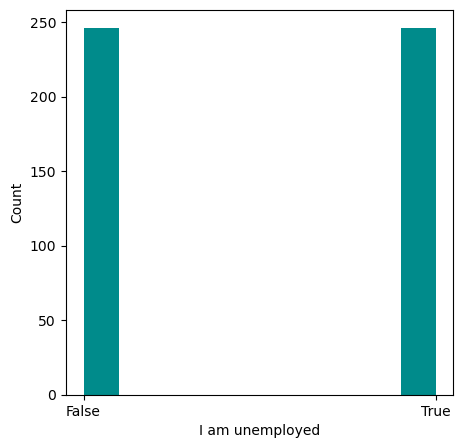

In [32]:
#y_sm.hist()
fig, ax = plt.subplots(figsize=(5,5))
ax.hist(y_sm, color='darkcyan')
ax.set_xlabel("I am unemployed")
ax.set_ylabel("Count")
ax.set_xticks([0,1])
ax.set_xticklabels(['False','True'])
plt.savefig('../img/class_rebalance_smote.png', bbox_inches="tight")
plt.show()

,feature,ranking
0,I identify as having a mental illness,1
1,Education,1
2,I have my own computer separate from a smart p...,1
3,I have been hospitalized before for my mental ...,1
4,I am legally disabled,1
5,I have my regular access to the internet,1
6,I live with my parents,1
7,I have a gap in my resume,1
8,I read outside of work and school,1
9,I receive food stamps,1


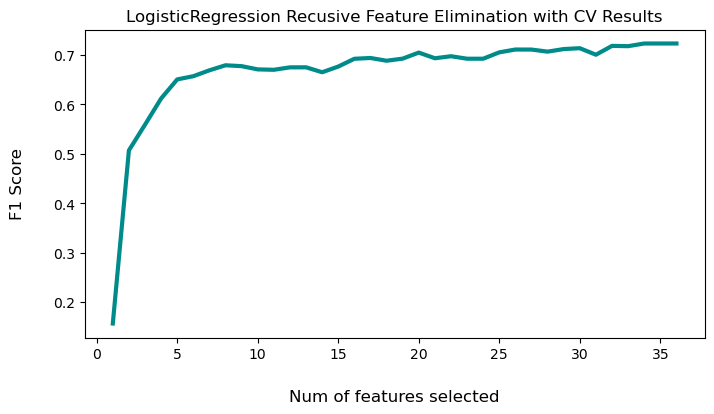

Optimal number of features: 34
Re-run the model with only the most important features of the same train-test split data used in the previous modeling so we can accurately compare the results.

Accuracy: 0.71
Precision: 0.69
Recall: 0.76
F1: 0.72


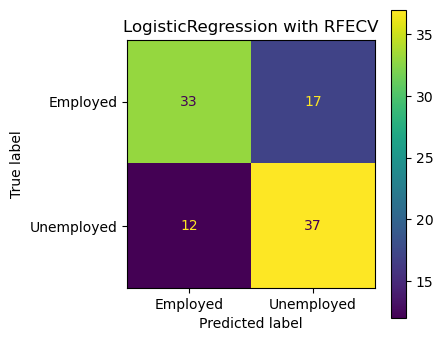

In [100]:
X_most_imp_log_reg_smote, lr_smote_rfe_model = run_rfe(X_sm, y_sm, LogisticRegression(random_state=random_seed), base_filename='logistic_regression_smote', scale_features=True)

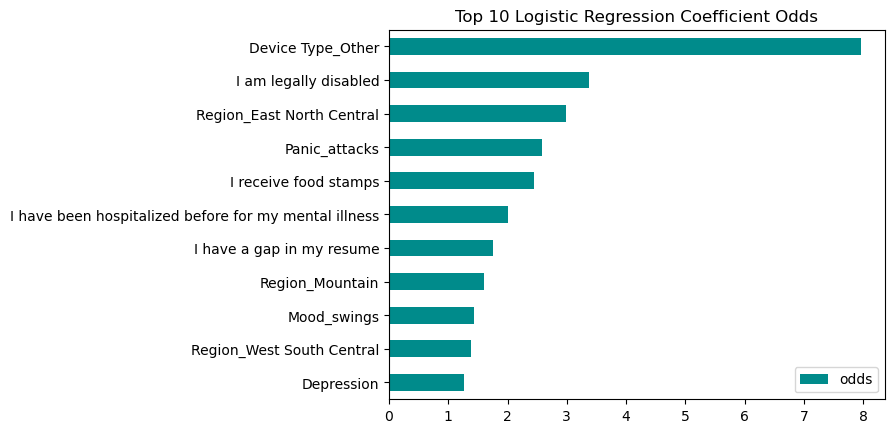

In [101]:
#logistic regression coeffiecients are in log odds, so need to be converted to regular odds
odds = np.exp(lr_smote_rfe_model.coef_).round(2)

odds_df = pd.DataFrame(data=odds.T, index=X_most_imp_log_reg_smote.T, columns=['odds']).sort_values(by='odds', ascending=True)
odds_df[-11:].plot.barh(title='Top 10 Logistic Regression Coefficient Odds', color='darkcyan')
plt.savefig('../img/logistic_regression_top_coeffs.png', bbox_inches="tight")

,feature,ranking
0,I identify as having a mental illness,1
1,Education,1
2,I have my own computer separate from a smart p...,1
4,How many days were you hospitalized for your m...,1
5,I am legally disabled,1
6,I have my regular access to the internet,1
7,I live with my parents,1
8,I have a gap in my resume,1
9,Total gaps in resume in months,1
10,Annual income (including any social welfare pr...,1


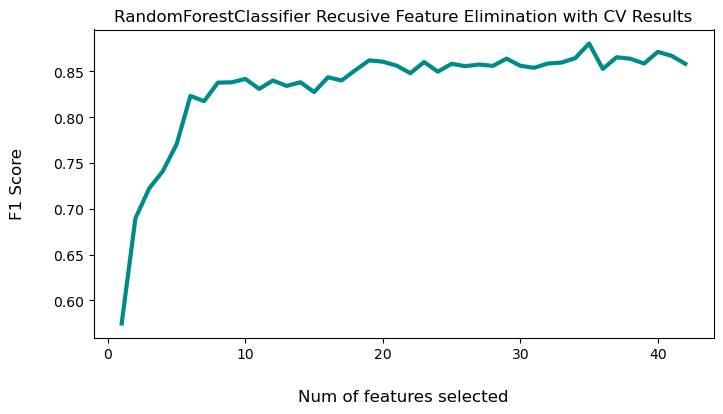

Optimal number of features: 35
Re-run the model with only the most important features of the same train-test split data used in the previous modeling so we can accurately compare the results.

Accuracy: 0.8
Precision: 0.82
Recall: 0.76
F1: 0.79


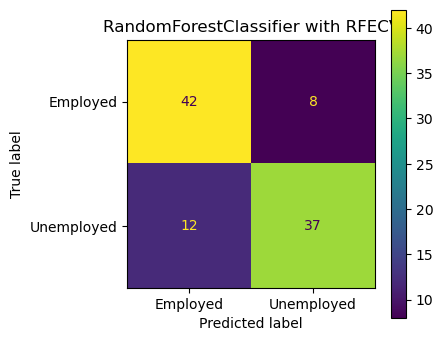

In [34]:
X_most_imp_rand_for_smote, rf_smote_rfe_model = run_rfe(X_sm, y_sm, RandomForestClassifier(random_state=random_seed), base_filename='rand_forest_smote')

#### Feature Importances

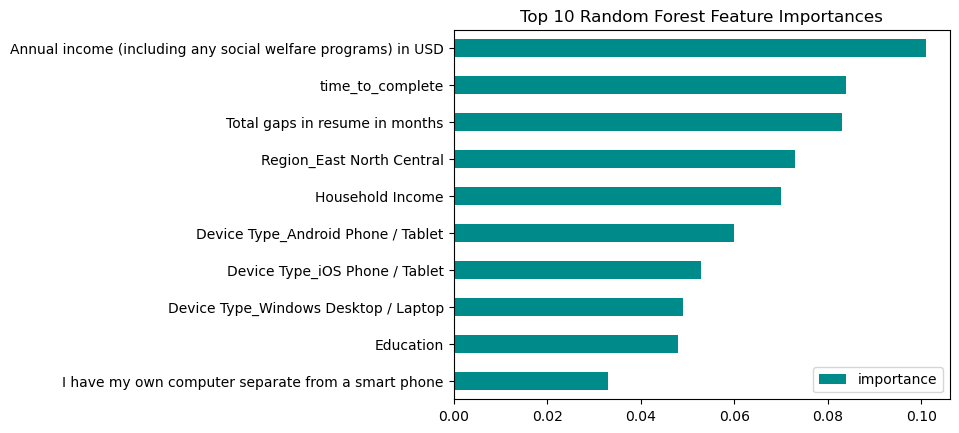

In [93]:
z = pd.DataFrame(index=X_most_imp_rand_for_smote, data=rf_smote_rfe_model.feature_importances_, columns=['importance']).sort_values(by='importance', ascending=True).round(3)
z[-10:].plot.barh(title='Top 10 Random Forest Feature Importances', color='darkcyan')
plt.savefig('../img/rand_forest_top_importances.png', bbox_inches="tight")

# Possible Additional Steps
- PCA?